# Problem 6.1 (parts a, b, d)

Attribution: Elena and Shashank

Before anything else, we import the modules we'll need.

In [1]:
import itertools
import warnings
import time

# Our numerical workhorses
import numpy as np
from numpy import trapz
import pandas as pd
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Part a

The probability distribution for catastrophe times for a three-step process ($m=3$) has been defined as:


\begin{align}
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) = \frac{1}{\tau_1\tau_2\tau_3}\int_0^t\mathrm{d}t_1 \int_{t_1}^t\mathrm{d}t_2\, \mathrm{e}^{-t_1/\tau_1}\,\mathrm{e}^{-(t_2-t_1)/\tau_2}\,\mathrm{e}^{-(t-t_2)/\tau_3}.
\end{align}

This is because we are working under the assumption that each subprocess that contributes towards a catastrophe event is essentially a Poisson process, with each subprocess occuring independently of each other at a defined rate $1/\tau_j$. For a three step process, the number of independent random variables $(X_i)$ would be two, which explains why we are integrating over $t_1$ to t and then 0 to t.

We can simplify the above expression by pairing $\tau_1$, $\tau_2$, and $\tau_3$ with their respective exponential terms to get:

\begin{align}
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) = \int_0^t\mathrm{d}t_1 \int_{t_1}^t\, \big[ R_1 . \mathrm{e}^{-R_1 . \Delta t_1}\,R_2 . \mathrm{e}^{-R_2 . \Delta t_2}\,R_3 . \mathrm{e}^{-R_3 . \Delta t_3}\big] \mathrm{d}t_2 \\
\text {where} && R_1 = \frac{1}{\tau_1}, \,\,R_2 = \frac{1}{\tau_2},\,\, R_3 = \frac{1}{\tau_3} \\
\\
\text {and} && \Delta t_1 = t_1,\,\, \Delta t_2 = t_2-t_1, \,\, \Delta t_3 = t - t_2
\end{align}

If the three subprocesses take $t_1$, $t_2$, and $t_3$ to complete, then the waiting time for the first subprocess, between the first and the second subprocess, and between the second and the third subprocess would be $t_1$, $t_2-t_1$, and $t-t_2$, respectively. These waiting times will then be a part of an exponential distribution, with parameter $\lambda_i$, which in this case is $1/\tau_i$, where $i \in \{1,2\dots m\}$. Hence, the expression for the probability distribution for catastrophe times is nothing but the product of three exponential functions (waiting times between three independent Poisson processes) with parameters as described above. 

We solve the second integral (containing $\mathrm{d}t_2$) before solving the first one because $t_1$ is contained within $t_2$.

# Part b

We generalized the expression for the probability distribution for catastrophe times for $m$ subprocesses and were left with:
\begin{align}
\\
P(t\mid \{\tau_j\}, m, I) = \sum_{j=1}^m \frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m (\tau_j - \tau_k)}
\\
\end{align}

Using this expression, the probability distributions for $m=1$ and $m=2$ were found to be:

\begin{align}
P(t\mid \tau_1, 1, I) &= \frac{\mathrm{e}^{-t/\tau_1}}{\tau_1} &&\text{and},\\[1em]
P(t\mid \tau_1, \tau_2, 2, I) &=
\frac{\mathrm{e}^{-t/\tau_2} - \mathrm{e}^{-t/\tau_1}}{\tau_2 - \tau_1} \\[1em]
\end{align}

Let's evaluate the probability distribution for $m=2$ for two arbitrary values of $\tau_1$ = 2 and $\tau_2$ = 5, satisfying the condition $\tau_1$ < $\tau_2$.

\begin{align}
P(t\mid \tau_1 = 2, \tau_2 = 5, 2, I) &=
\frac{\mathrm{e}^{-t/2}}{2 - 5} + \frac{\mathrm{e}^{-t/5}}{5 - 2}
= \frac{\mathrm{e}^{-t/5} - \mathrm{e}^{-t/2}}{3} &&\text{for all t}\in D\\[1em]
\end{align}

Now let's switch the values for $\tau_1$ and $\tau_2$ such that $\tau_1$ = 5 and $\tau_2$ = 2, satisfying the condition $\tau_1$ > $\tau_2$.

\begin{align}
P(t\mid \tau_1 = 5, \tau_2 = 2, 2, I) &=
\frac{\mathrm{e}^{-t/5}}{5 - 2} + \frac{\mathrm{e}^{-t/2}}{2 - 5}
= \frac{\mathrm{e}^{-t/5} - \mathrm{e}^{-t/2}}{3} &&\text{for all t}\in D\\[1em]
\end{align}

As can be seen above, the probability distribution function is unable to differentiate between the two set of values for $\tau$. In order to avoid having this degeneracy, we will have to select one of the two conditions, either $\tau_i$ < $\tau_{i+1}$, or $\tau_i$ > $\tau_{i+1}$,  for $i \in$ len(D). However, we should take note of the fact that even though the order of these rates ($\tau$) might be important biologically (i.e. one process has to occur in order for the second one to start), the order does not matter from a mathematical point of view (Commutative propoerty of multiplication).
Hence, we specify that $\tau_1 < \tau_2 < \tau_3 \dots \tau_n$ before doing model selection and parameter estimation.

# Part d

First we read in the data as a Pandas `DataFrame`.

In [4]:
df = pd.read_csv("./data/gardner_hw6/gardner_mt_catastrophe_only_tubulin.csv", comment="#")
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35,25,50,60
1,40.000,45,40,60,75
2,40.000,50,40,60,75
3,45.429,50,45,75,85
4,50.000,55,50,75,115


Next we recreate the same functions we wrote for PTMCMC in part (c). We will end up needing to use these again. (Apologies again for having to submit these as separate notebooks.)

In [2]:
def log_likelihood(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    We are very proud of this function.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return the sum of the log likelihoods
    return np.sum(log_like)

def log_prior(tau, m, tau_min, tau_max):
    """
    Log prior for model defined above. Takes in m and tau, 
    returns log prior.
    """
    # check that tau is ordered least to greatest
    for i in range(m-1):
        if not (tau[i] + 1e-6) < tau[i+1]:
            return -np.inf
    
    # check that tau is not outside the boundaries we define
    if tau[0] < tau_min or tau[-1] > tau_max:
        return -np.inf
    
    prior = np.empty(m)
    # calculate and store the elements of the normalized prior 
    # associated with each tau 
    for i in range(m):
        if m == 1:
            prior[i] = tau[i] * np.log(tau_max / tau_min)
        
        elif m > 1 and i == 0:
            prior[i] = tau[i] * np.log(tau[i+1] / tau_min)
        
        elif m > 1 and i == m-1:
            prior[i] = tau[i] * np.log(tau_max / tau[i-1])
        
        else:
            prior[i] = tau[i] * np.log(tau[i+1] / tau[i-1])
            
    return -np.log(np.prod(prior))
        
def tau_start(m, n_walkers, n_temps):
    """
    Generates starting points for each tau.
    """
    p = np.empty((n_temps, n_walkers, m))
    
    for i in range(m):
        p[:,:,i] = np.random.exponential(300, (n_temps,n_walkers))
    return p

def sample_ptmcmc(data, m, model, tau_min=1, tau_max=1800, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using PTMCMC.
    """
    # arguments for likelihood
    loglargs = (data, m)
    
    # arguments for prior
    logpargs = (m, tau_min, tau_max)
    
    # starting points for the parameters
    p0 = tau_start(m, n_walkers, n_temps)
    
    # column headings for outputted DataFrames
    columns = {'m = 1': ['tau_1'],
               'm = 2': ['tau_1', 'tau_2'],
               'm = 3': ['tau_1', 'tau_2', 'tau_3'],
               'm = 4': ['tau_1', 'tau_2', 'tau_3', 'tau_4'],
               'm = 5': ['tau_1', 'tau_2', 'tau_3', 'tau_4', 'tau_5']}
    
    return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            threads=threads, columns=columns[model], return_lnZ=True)

def log_likelihood_t(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    Returns the log_likelihoods for all datapoints 
    in an array.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return array of the log likelihoods
    return log_like

def post_plot(tau, t, m, tau_min, tau_max):
    return np.exp(log_likelihood_t(tau, t, m) + log_prior(tau, m, tau_min, tau_max))

We then attempted to do parameter estimation for the other tubulin concentrations using `emcee`'s Ensemble sampler, since we are only interested in the posterior distributions and don't need to perform model selection again. We defined the functions below in order to run the Ensemble sampler.

In [57]:
def log_posterior(p, t, m=3, tau_min=1, tau_max=1800):
    """
    Calculates the log posterior using our best model.
    """
    tau_1, tau_2, tau_3 = p
    
    # check that tau is ordered least to greatest
    if not (tau_1 + 1e-6) < tau_2 and (tau_2 + 1e-6) < tau_3:
        return -np.inf
    
    # check that tau is not outside the boundaries we define
    if tau_1 < tau_min or tau_3 > tau_max:
        return -np.inf
    
    return log_likelihood(p, t, m) + log_prior(p, m, tau_min, tau_max)

def sample_mcmc(data, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using MCMC. Written for use
    with our best model.
    """
    p0 = np.empty((300, n_walkers, 3))
    p0[:,:,0] = np.random.exponential(300, (n_walkers, 3)) 
    p0[:,:,1] = np.random.exponential(300, (n_walkers, 3)) 
    p0[:,:,2] = np.random.exponential(300, (n_walkers, 3)) 

    columns = ['tau_1', 'tau_2', 'tau_3'] 

    args = (data,)

    return bebi103.run_ensemble_emcee(log_posterior, n_burn=n_burn, 
                                      n_steps=n_steps, n_walkers=n_walkers, 
                                      p0=p0, columns=columns, 
                                      args=args, threads=3)                    

Unfortunately, when we attempted to run the Ensemble sampler with these functions, we kept getting `Nan`s for `lnprob`, which caused `emcee` to throw an error. We couldn't figure out the reason for this, but we expect it is tied to the same problem we experienced with  PTMCMC in part (c). In the end, we decided to just go ahead and run PTMCMC here too, since we knew how to circumvent this issue as long as we use the PT sampler.

In [5]:
start = time.time()
df_7uM, lnZ_7uM, dlnZ_7uM = sample_ptmcmc(df['7 uM'].dropna(), 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The first PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_9uM, lnZ_9uM, dlnZ_9uM = sample_ptmcmc(df['9 uM'].dropna(), 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The second PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_10uM, lnZ_10uM, dlnZ_10uM = sample_ptmcmc(df['10 uM'].dropna(), 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The third PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_14uM, lnZ_14uM, dlnZ_14uM = sample_ptmcmc(df['14 uM'].dropna(), 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The fourth PTMCMC took ', time.time()-start, ' seconds.')

The first PTMCMC took  995.2930941581726  seconds.
The second PTMCMC took  984.1313531398773  seconds.
The third PTMCMC took  1047.5016250610352  seconds.
The fourth PTMCMC took  1106.8903830051422  seconds.


As usual, we first look at the results using `corner` plots.

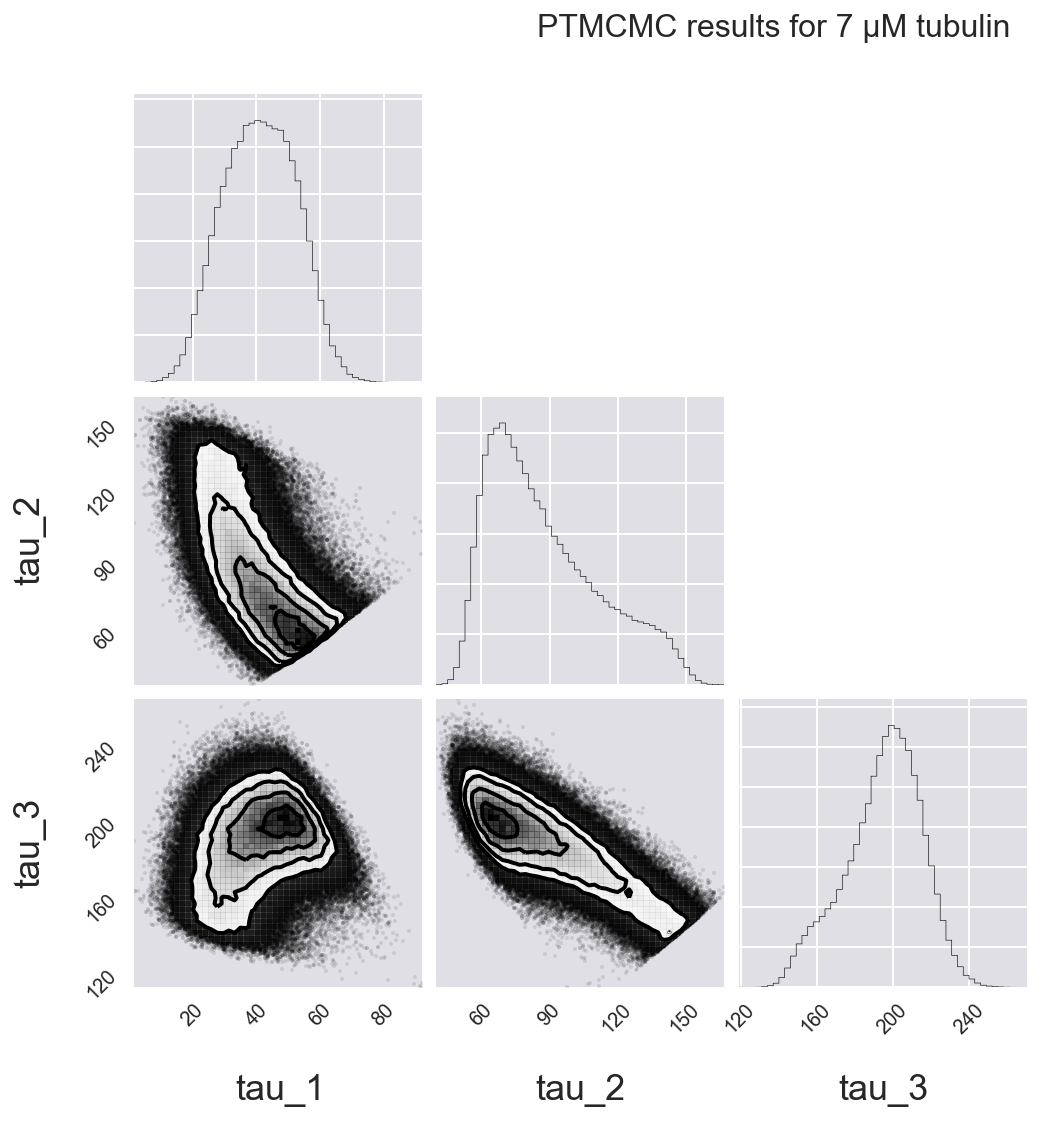

In [60]:
a = corner.corner(df_7uM[(df_7uM.beta_ind==0)][['tau_1', 'tau_2', 'tau_3']], bins=50)
a.text(0.5, 1, 'PTMCMC results for 7 µM tubulin', fontsize=16)

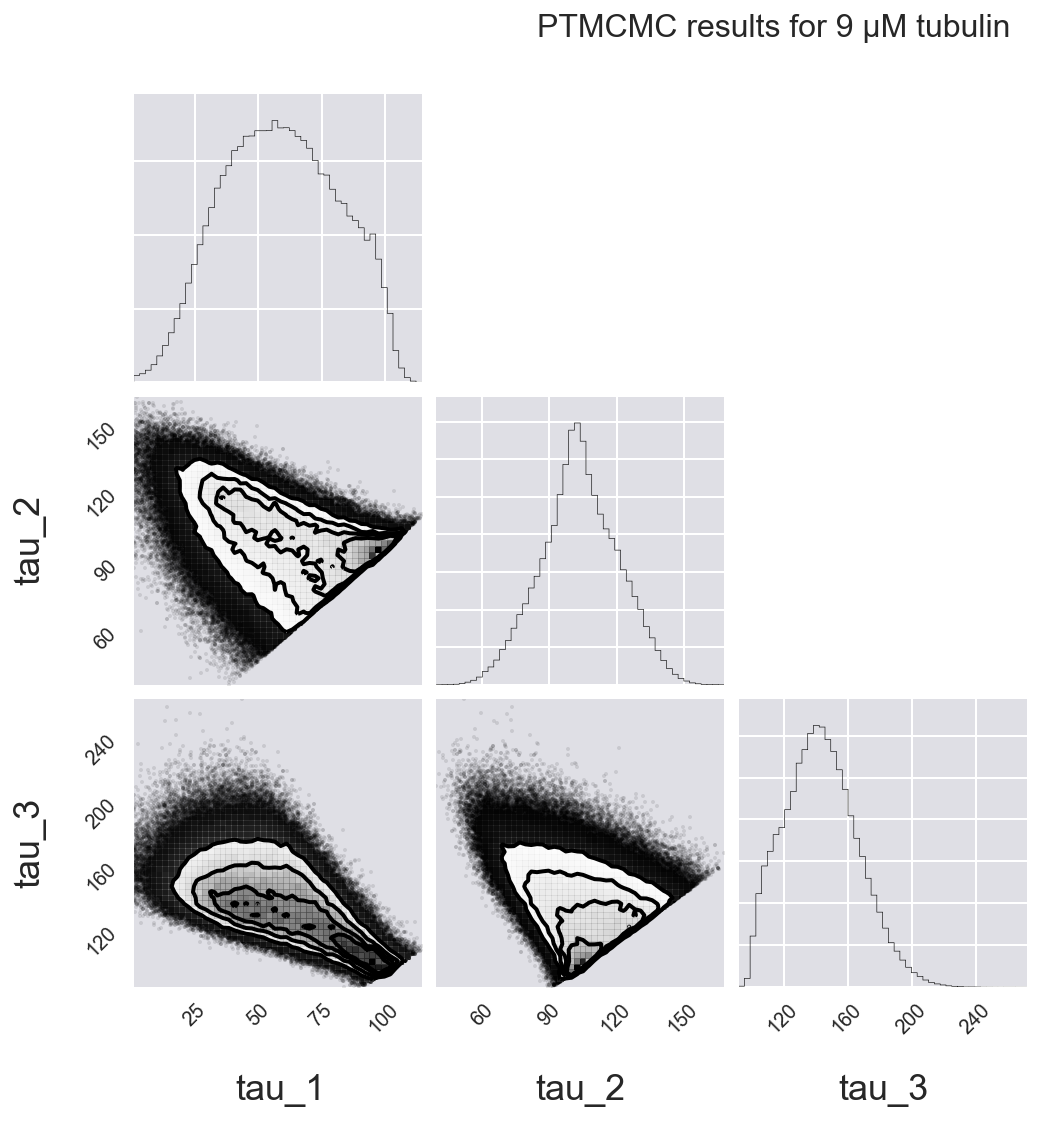

In [61]:
a = corner.corner(df_9uM[(df_9uM.beta_ind==0)][['tau_1', 'tau_2', 'tau_3']], bins=50)
a.text(0.5, 1, 'PTMCMC results for 9 µM tubulin', fontsize=16)

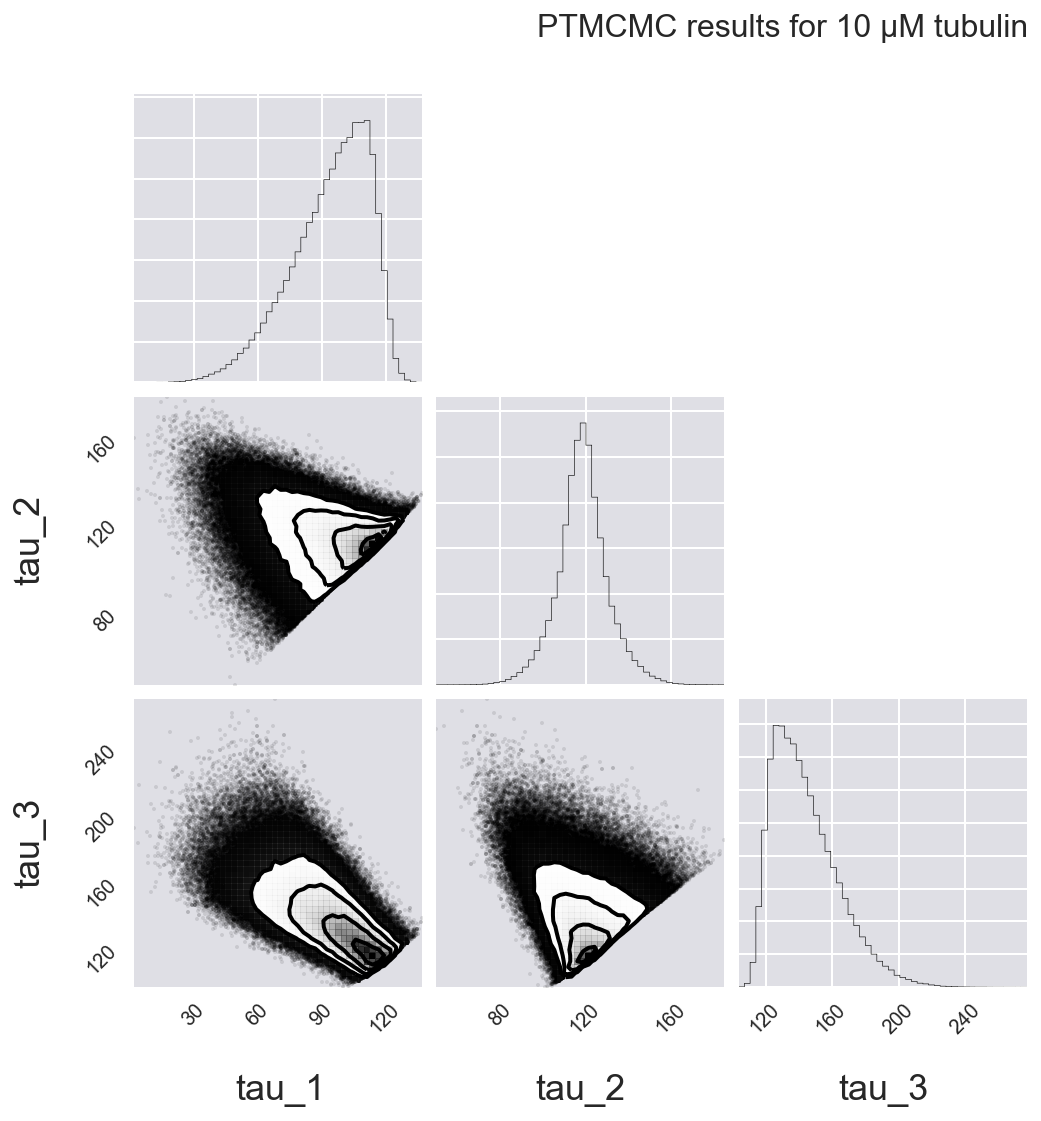

In [62]:
a = corner.corner(df_10uM[(df_10uM.beta_ind==0)][['tau_1', 'tau_2', 'tau_3']], bins=50)
a.text(0.5, 1, 'PTMCMC results for 10 µM tubulin', fontsize=16)

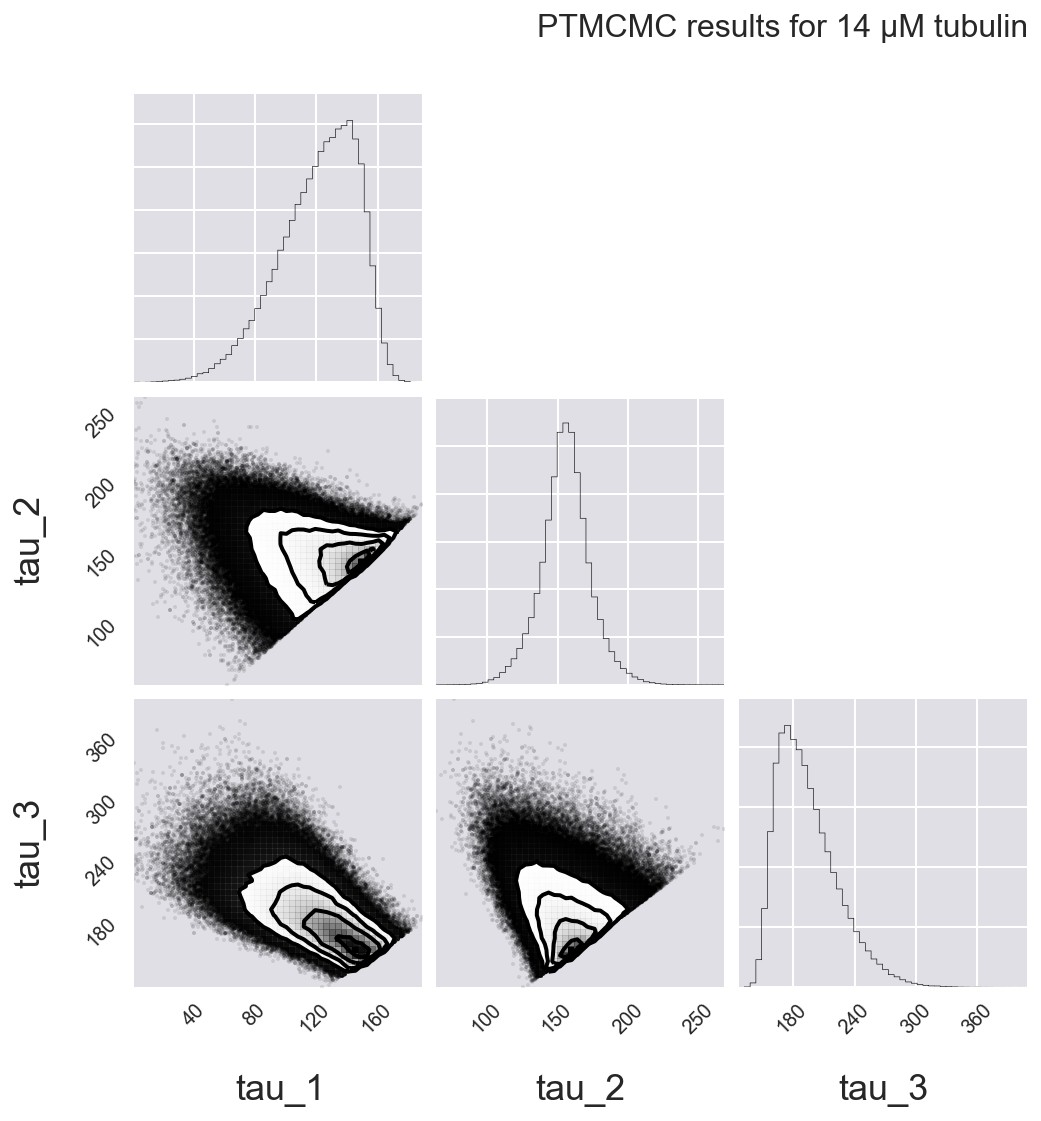

In [63]:
a = corner.corner(df_14uM[(df_14uM.beta_ind==0)][['tau_1', 'tau_2', 'tau_3']], bins=50)
a.text(0.5, 1, 'PTMCMC results for 14 µM tubulin', fontsize=16)

Although the exact shapes of the posteriors change across different tubulin concentrations, they are all peaked and unimodal. 

Next, we calculate the MAPs and plot our ECDFs and theoretical CDFs for each tubulin concentration, similar to what we did in part (c) to check that PTMCMC gave us reasonable results.

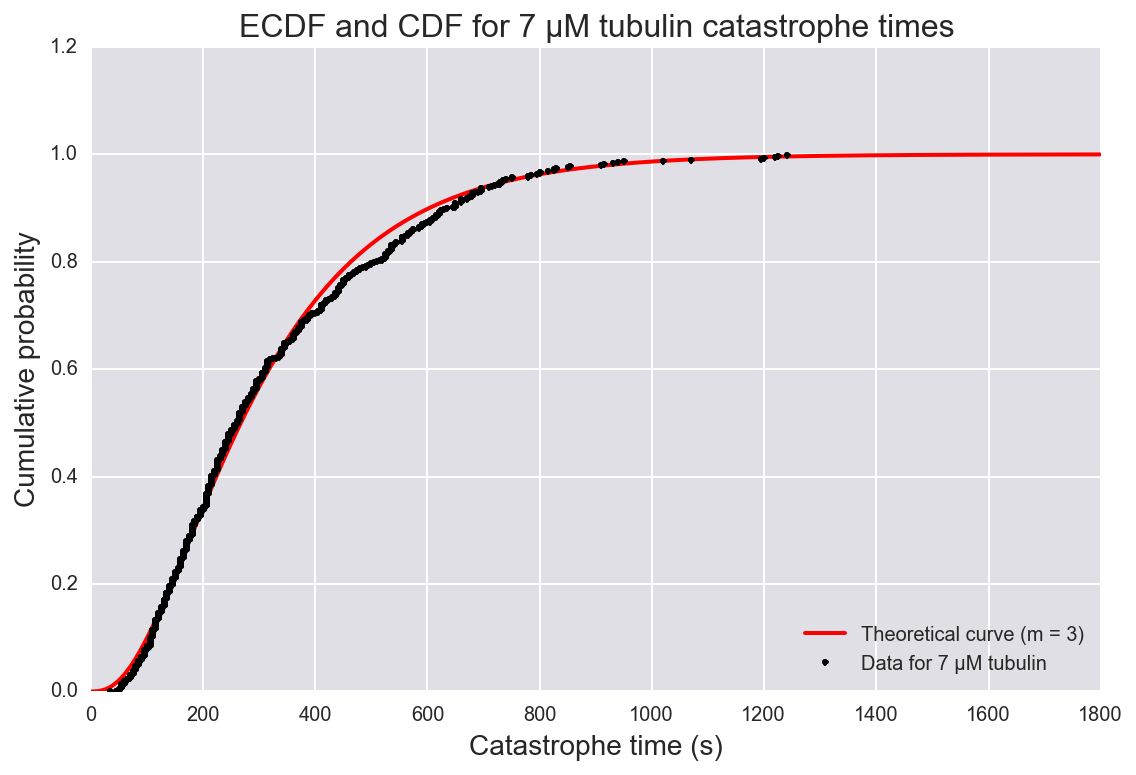

In [64]:
# for 7 µM tubulin

# restrict PTMCMC output to the first temperature and drop all rows
# that have lnlike = -inf
df7uM_map = df_7uM[(df_7uM.beta_ind==0) & (df_7uM.lnlike != -np.inf)]

# generate array of tau MAPs
tau_map_7uM = np.array([df7uM_map['tau_1'].median(), df7uM_map['tau_2'].median(),
                     df7uM_map['tau_3'].median()])

# caculate theoretical CDF
post7uM = post_plot(tau_map_7uM, np.arange(1800), 3, 1, 1800)
# drop the first value in the array because it is Nan
post7uM = post7uM[1:]
post7uM_area = trapz(post7uM, dx=1)
post7uM_norm = post7uM / post7uM_area
post7uM_cdf = np.cumsum(post7uM_norm)

df7_dropna = df['7 uM'].dropna()

# Build ECDF
y = np.arange(len(df7_dropna)) / len(df7_dropna)
x = np.sort(df7_dropna.values)

# Plot ECDF and theoretical CDFs for different values of m
plt.plot(np.arange(1799), post7uM_cdf, color='r')
plt.plot(x, y, '.', color='k')
plt.xlabel('Catastrophe time (s)', fontsize=14)
plt.ylabel('Cumulative probability', fontsize=14)
plt.title('ECDF and CDF for 7 µM tubulin catastrophe times',
          fontsize=16)
plt.legend(['Theoretical curve (m = 3)', 'Data for 7 µM tubulin'], loc=4)
plt.tight_layout()

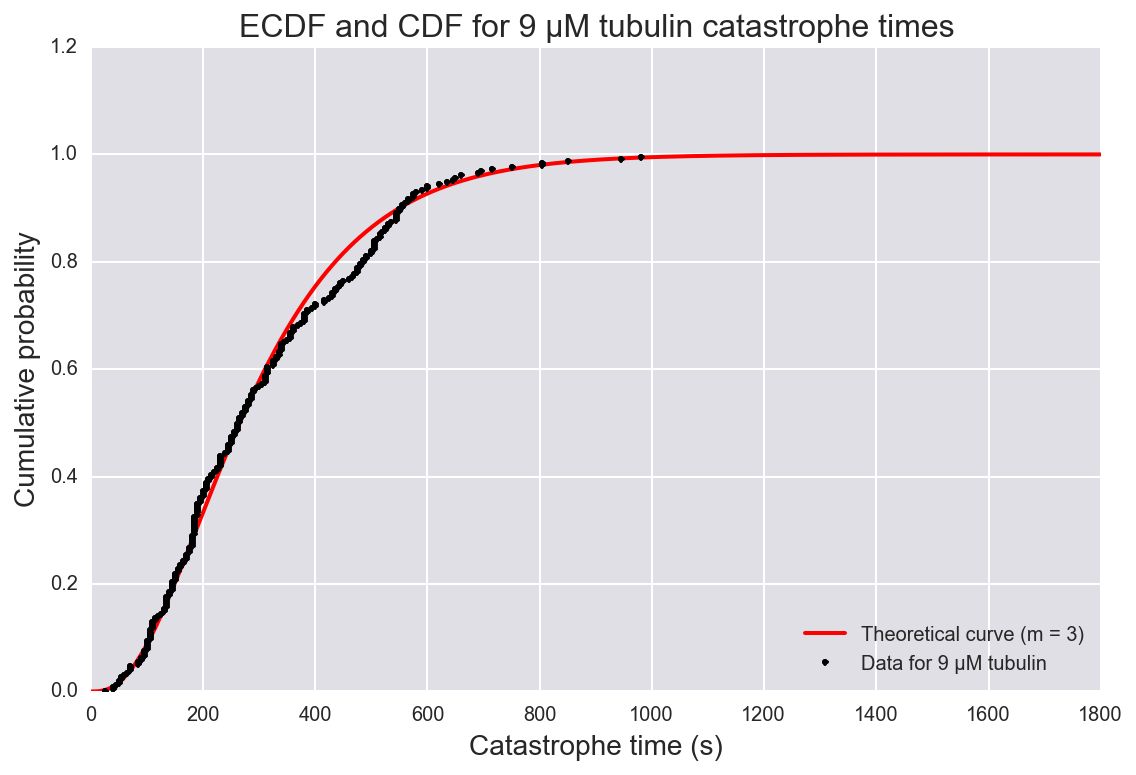

In [34]:
# for 9 µM tubulin

# restrict PTMCMC output to the first temperature and drop all rows
# that have lnlike = -inf
df9uM_map = df_9uM[(df_9uM.beta_ind==0) & (df_9uM.lnlike != -np.inf)]

# generate array of tau MAPs
tau_map_9uM = np.array([df9uM_map['tau_1'].median(), df9uM_map['tau_2'].median(),
                     df9uM_map['tau_3'].median()])

# calculate theoretical CDF
post9uM = post_plot(tau_map_9uM, np.arange(1800), 3, 1, 1800)
post9uM_area = trapz(post9uM, dx=1)
post9uM_norm = post9uM / post9uM_area
post9uM_cdf = np.cumsum(post9uM_norm)

df9_dropna = df['9 uM'].dropna()

# Build ECDF
y = np.arange(len(df9_dropna)) / len(df9_dropna)
x = np.sort(df9_dropna.values)

# Plot ECDF and theoretical CDFs for different values of m
plt.plot(np.arange(1800), post9uM_cdf, color='r')
plt.plot(x, y, '.', color='k')
plt.xlabel('Catastrophe time (s)', fontsize=14)
plt.ylabel('Cumulative probability', fontsize=14)
plt.title('ECDF and CDF for 9 µM tubulin catastrophe times',
          fontsize=16)
plt.legend(['Theoretical curve (m = 3)', 'Data for 9 µM tubulin'], loc=4)
plt.tight_layout()

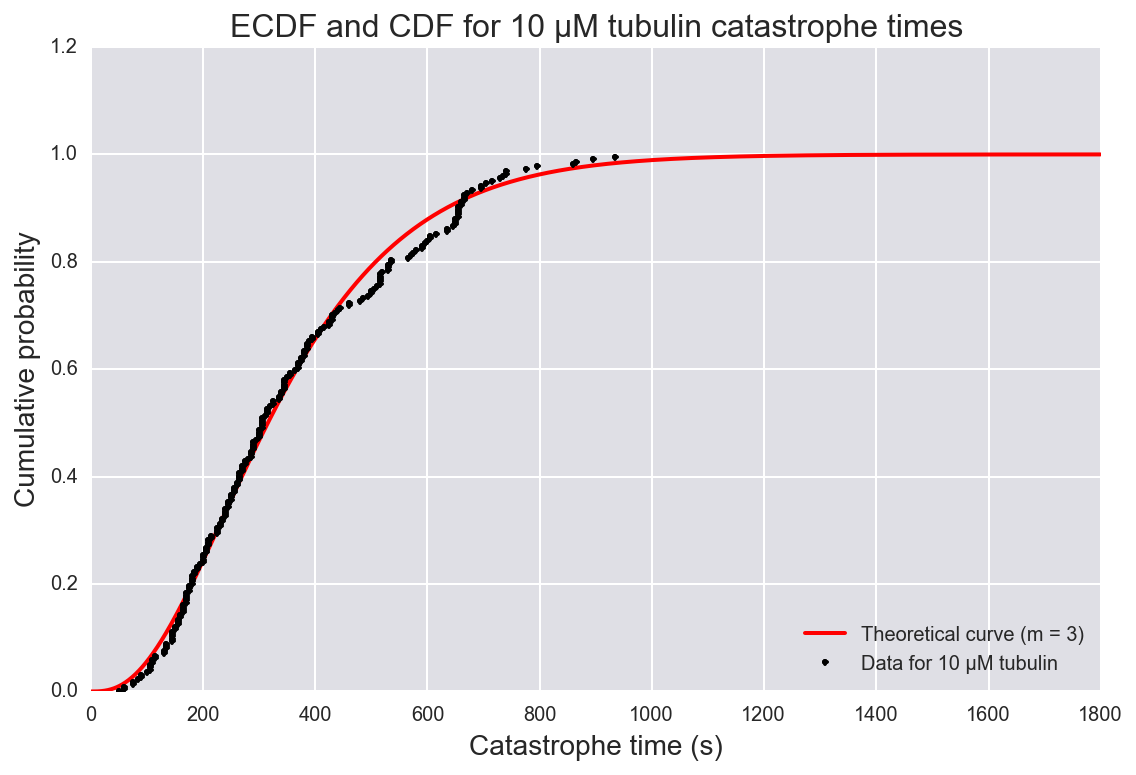

In [35]:
# for 10 µM tubulin

# restrict PTMCMC output to the first temperature and drop all rows
# that have lnlike = -inf
df10uM_map = df_10uM[(df_10uM.beta_ind==0) & (df_10uM.lnlike != -np.inf)]

# generate array of tau MAPs
tau_map_10uM = np.array([df10uM_map['tau_1'].median(), df10uM_map['tau_2'].median(),
                     df10uM_map['tau_3'].median()])

# calculate theoretical CDF
post10uM = post_plot(tau_map_10uM, np.arange(1800), 3, 1, 1800)
post10uM_area = trapz(post10uM, dx=1)
post10uM_norm = post10uM / post10uM_area
post10uM_cdf = np.cumsum(post10uM_norm)

df10_dropna = df['10 uM'].dropna()

# Build ECDF
y = np.arange(len(df10_dropna)) / len(df10_dropna)
x = np.sort(df10_dropna.values)

# Plot ECDF and theoretical CDFs for different values of m
plt.plot(np.arange(1800), post10uM_cdf, color='r')
plt.plot(x, y, '.', color='k')
plt.xlabel('Catastrophe time (s)', fontsize=14)
plt.ylabel('Cumulative probability', fontsize=14)
plt.title('ECDF and CDF for 10 µM tubulin catastrophe times',
          fontsize=16)
plt.legend(['Theoretical curve (m = 3)', 'Data for 10 µM tubulin'], loc=4)
plt.tight_layout()

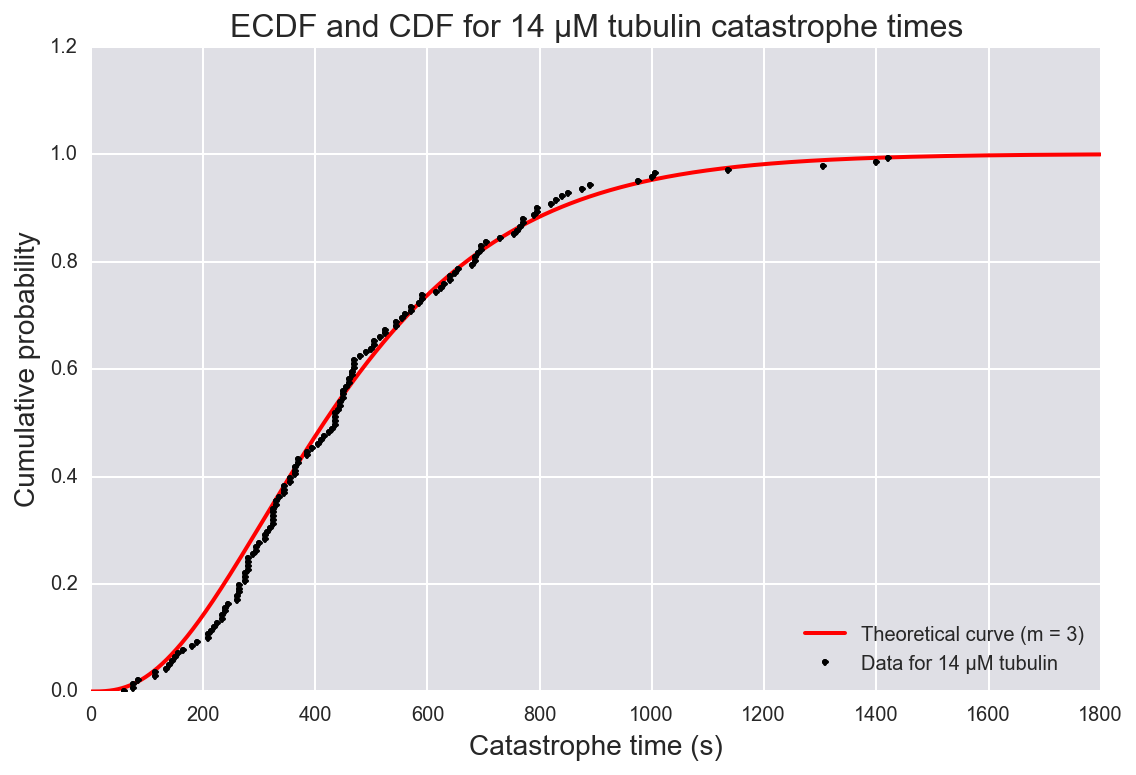

In [36]:
# for 14 µM tubulin

# restrict PTMCMC output to the first temperature and drop all rows
# that have lnlike = -inf
df14uM_map = df_14uM[(df_14uM.beta_ind==0) & (df_14uM.lnlike != -np.inf)]

# generate array of tau MAPs
tau_map_14uM = np.array([df14uM_map['tau_1'].median(), df14uM_map['tau_2'].median(),
                     df14uM_map['tau_3'].median()])

# caculate theoretical CDF
post14uM = post_plot(tau_map_14uM, np.arange(1800), 3, 1, 1800)
post14uM_area = trapz(post14uM, dx=1)
post14uM_norm = post14uM / post14uM_area
post14uM_cdf = np.cumsum(post14uM_norm)

df14_dropna = df['14 uM'].dropna()

# Build ECDF
y = np.arange(len(df14_dropna)) / len(df14_dropna)
x = np.sort(df14_dropna.values)

# Plot ECDF and theoretical CDFs for different values of m
plt.plot(np.arange(1800), post14uM_cdf, color='r')
plt.plot(x, y, '.', color='k')
plt.xlabel('Catastrophe time (s)', fontsize=14)
plt.ylabel('Cumulative probability', fontsize=14)
plt.title('ECDF and CDF for 14 µM tubulin catastrophe times',
          fontsize=16)
plt.legend(['Theoretical curve (m = 3)', 'Data for 14 µM tubulin'], loc=4)
plt.tight_layout()

As we expected, all of the theoretical CDFs look like quite reasonable models with respect to the ECDFs. 

Next we wanted to plot $\tau_j$ against tubulin concentration. (Unfortunately we had to leave out the 12 µM data series because the PTMCMC outputs for that were calculated in a separate notebook, and we were unable even to write those outputs to a CSV file because of an error related to already having "too many files open".) 

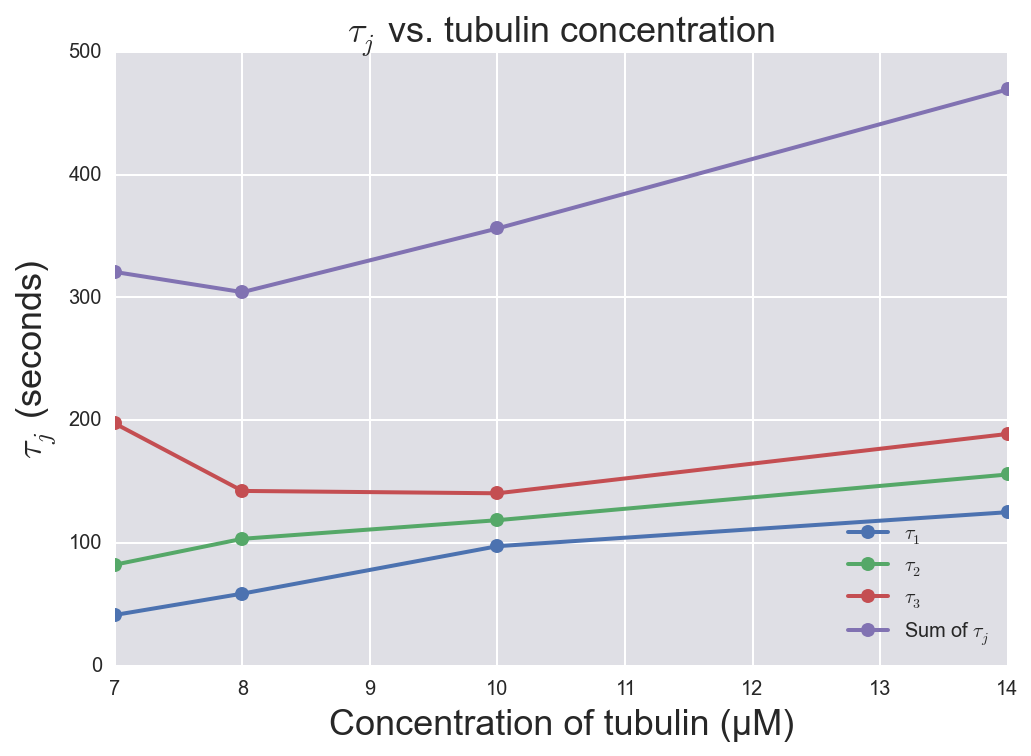

In [68]:
# put the tau MAPs for all tubulin concentrations in a single array
tau_map_all = np.array([tau_map_7uM, tau_map_9uM, tau_map_10uM, tau_map_14uM])

# define the array of tubulin concentrations
concentrations = np.array([7, 8, 10, 14])

# also find the sum of tau_j for each concentration and store in an array
tau_map_sum = np.sum(tau_map_all, axis=1)

# plot tau_j vs tubulin concentration
plt.plot(concentrations, tau_map_all[:,0], marker='o')
plt.plot(concentrations, tau_map_all[:,1], marker='o')
plt.plot(concentrations, tau_map_all[:,2], marker='o')
plt.plot(concentrations, tau_map_sum, marker='o')
plt.legend([r'$\tau_1$', r'$\tau_2$', r'$\tau_3$', r'Sum of $\tau_j$'], loc=4)
plt.xlabel('Concentration of tubulin (µM)')
plt.ylabel(r'$\tau_j$ (seconds)')
plt.title(r'$\tau_j$ vs. tubulin concentration')

With the exception of the 7 µM tubulin condition, there seems to be a general trend of increasing values for $\tau_j$ as tubulin concentration increases. This at first seemed counterintuitive given that microtubules polymerize faster when the concentration of tubulin is higher. We naively thought that faster polymerization would mean that the microtubules would more quickly reach some threshold length beyond which catastrophes become more likely. 

However, in the course of reading online about microtubules, we came across some information that seems to account for the observed phenomenon of increasing time to catastrophe as tubulin concentration increases. According to a webpage for a cell biology course  at Rensselaer Polytechnic Institute,$^1$ the growing (plus) end of a microtubule is stabilized by a GTP cap. This cap forms because while b-tubulin hydrolyzes GTP when it comes into contact with a-tubulin (during/as a result of polymerization), this hydrolysis takes time and is outpaced by polymerization at high tubulin concentrations. The faster the tubulin polymerizes, the more of a stabilizing GTP cap it can build, and thus catastrophe becomes more infrequent. Conversely, as the tubulin concentration decreases and polymerization slows down, the probability increases that GTP will be hydrolyzed before the next tubulin dimer is added. Hydrolysis of GTP destabilizes the microtubule; loss of the GTP cap can initiate a catastrophe. 

$^1$ https://www.rpi.edu/dept/bcbp/molbiochem/MBWeb/mb2/part1/microtub.htm

In [69]:
df_7uM.to_csv('/Users/elenaperry/Desktop/df_7uM.csv')
df_9uM.to_csv('/Users/elenaperry/Desktop/df_9uM.csv')
df_10uM.to_csv('/Users/elenaperry/Desktop/df_10uM.csv')
df_14uM.to_csv('/Users/elenaperry/Desktop/df_14uM.csv')